# **MCBS: Final Project**
## Model 2: transfer learning 
 Pre-trained ResNeXt network provided in:
 
*Matek, C., Schwarz, S., Spiekermann, K.  et al.  Human-level recognition of blast cells in acute myeloid leukaemia with convolutional neural networks.  Nat Mach Intell   1,  538–544 (2019). https://doi.org/10.1038/s42256-019-0101-9*

used on a new dataset containing over 17,000 microscopic images of white blood cells.


*Acevedo, Andrea; Merino, Anna; Alferez, Santiago; Molina, Ángel; Boldú, Laura; Rodellar, José (2020), “A dataset for microscopic peripheral blood cell images for development of automatic recognition systems”, Mendeley Data, V1, doi: 10.17632/snkd93bnjr.1*

In [1]:
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import splitfolders
import shutil
import random
import sys
import os

Using TensorFlow backend.


In [2]:
# custom modules import
import importlib
sys.path.append('../modules')

for cust in ['test_module','residual_network']:
    if cust in sys.modules:
        importlib.reload(sys.modules[cust])
        
import test_module as tm
import residual_network

In [3]:
#set file paths
base_path  = "../data/pbc"
orig_data_path = f"{base_path}/orig"
split_data_path = f"{base_path}/split"
aug_data_path = f"{base_path}/split/train_aug_3000"

In [4]:
classes_dictionary_org = {'BA': 0, 'EO': 1,'ERB': 2,'IG': 3, 'LY': 4, 'MO': 5,'BNE': 6, 'PLATELET': 7 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}

abbreviation_dict = { 'BA':'basophil', 
                      'EO':'eosinophil',
                      'ERB':'erythroblast',
                      'IG':'ig',
                      'LY':'lymphocyte',
                      'MO':'monocyte',
                      'BNE':'neutrophil',
                      'PLATELET': 'platelet' }

dir_dictionary = {item: classes_dictionary_org[key] for key, item in abbreviation_dict.items()}

shape = 400
img_width, img_height = shape, shape
input_size = (img_width, img_height )

batch_size =  16

if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
else:
        input_shape = (img_width, img_height, 3)

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow_from_directory(aug_data_path, 
                                        class_mode = 'categorical', 
                                        target_size = input_size,
                                        batch_size = batch_size
                                        )

val_set = datagen.flow_from_directory(f"{split_data_path}/test/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size, 
                                      batch_size = batch_size)

test_set = datagen.flow_from_directory(f"{split_data_path}/test/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size,
                                        batch_size = batch_size,
                                      shuffle = False)


Found 24020 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.


## **Training**

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf

### **Pre-trained ResNeXt**

Taking advantage of the similarity of both data sets, the model used in Matek et al. (2019) has been used to classify PBC data. 

In [9]:
epoch_num = 20  # @param {type: "slider", min:1, max:100}

epoch_steps = train_set.samples//batch_size
val_steps = val_set.samples//batch_size

print(f"Train set:   {train_set.samples} images")
print(f"Test set:    {test_set.samples} images")
print(f"Validation set: {val_set.samples} images\n")

print(f"Number of epochs: {epoch_num}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {epoch_steps}")
print(f"Validation steps: {val_steps}")

Train set:   24020 images
Test set:    1716 images
Validation set: 1716 images

Number of epochs: 20
Batch size: 16
Steps per epoch: 1501
Validation steps: 107


In [10]:
img_height = 400
img_width = 400
img_channels = 3
num_of_classes = 8

base_model = residual_network.residual_network()

weight_file_path = f'../models/resnext_orig/weights.hdf5'
base_model.load_weights(weight_file_path)
base_model.trainable = False 

# get all the layers from pre-trained network apart from the last one 
x = base_model.layers[-2].output

#add last layer adjusted to the new dataset 
top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
network_output = layers.Dense(8, activation='softmax')(x)

#build and compile new model
model = models.Model(inputs=base_model.inputs, outputs=[network_output])

#model.load_weights('../models/adj_resnet_pbc_3k_20e/weights.h5')

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.01),
              metrics=["accuracy"])

In [ ]:
history = model.fit(
        train_set,
        batch_size=batch_size,
        validation_data = val_set,
        validation_steps = val_steps,
        steps_per_epoch = epoch_steps,
        epochs = epoch_num)

### **Fine-tuning**

In [8]:
# unfreeze all the layers except for BatchNormalization to fine-tune the network
for layer in model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True
    
#re-compile the model
model.compile(loss="categorical_crossentropy", 
        optimizer=Adam(learning_rate=0.00001),
        metrics=["accuracy"])

In [9]:
history = model.fit(
        train_set,
        batch_size=batch_size,
        validation_data = val_set,
        validation_steps = val_steps,
        steps_per_epoch = epoch_steps,
        epochs = epoch_num)

Epoch 1/20
1501/1501 [==============================] - 1058s 705ms/step - loss: 0.8671 - accuracy: 0.6972 - val_loss: 0.4644 - val_accuracy: 0.8481
Epoch 2/20
1501/1501 [==============================] - 1052s 701ms/step - loss: 0.5331 - accuracy: 0.8237 - val_loss: 0.3969 - val_accuracy: 0.8586
Epoch 3/20
1501/1501 [==============================] - 1050s 699ms/step - loss: 0.4409 - accuracy: 0.8529 - val_loss: 0.3544 - val_accuracy: 0.8692
Epoch 4/20
1501/1501 [==============================] - 1049s 699ms/step - loss: 0.3773 - accuracy: 0.8752 - val_loss: 0.3124 - val_accuracy: 0.8896
Epoch 5/20
1501/1501 [==============================] - 1049s 699ms/step - loss: 0.3398 - accuracy: 0.8905 - val_loss: 0.2686 - val_accuracy: 0.9019
Epoch 6/20
1501/1501 [==============================] - 1049s 699ms/step - loss: 0.3064 - accuracy: 0.9004 - val_loss: 0.3000 - val_accuracy: 0.8954
Epoch 7/20
1501/1501 [==============================] - 1047s 697ms/step - loss: 0.2786 - accuracy: 0.9077

In [10]:
tm.save_model(model, "model2_pbc_ft", history)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/model2_pbc_ft/assets


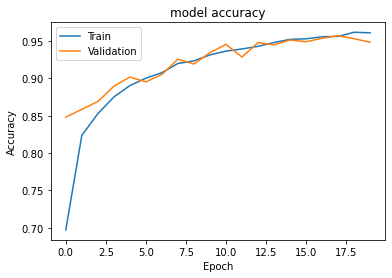

In [11]:
tm.plot_hist(history.history)

## **Model performance**

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image

In [8]:
labels = [abbreviation_dict[classes_dictionary[i]] for i in range(8)]

In [9]:
model_name ='model2_pbc_ft'

model = models.load_model(f'../models/{model_name}/')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'], 
              )

In [10]:
test_loss, test_acc  = model.evaluate(test_set)
y_test = test_set.classes
y_pred_prob = model.predict(test_set)
y_pred = y_pred_prob.argmax(axis=1)

108/108 [==============================] - 19s 179ms/step - loss: 0.1764 - accuracy: 0.9487


In [11]:
pd.options.display.float_format = '{:,.2f}'.format

df = tm.CM_measures(confusion_matrix(y_test, y_pred), labels=labels)
df[['Accuracy','Precision','Sensitivity', 'Support']]

,Accuracy,Precision,Sensitivity,Support
basophil,0.99,0.97,0.90,123
eosinophil,1.00,1.00,0.98,313
erythroblast,1.00,0.98,0.97,156
ig,0.96,0.83,0.96,290
lymphocyte,0.99,0.96,0.95,122
monocyte,0.98,0.88,0.90,142
neutrophil,0.98,0.99,0.90,334
platelet,1.00,1.00,1.00,236


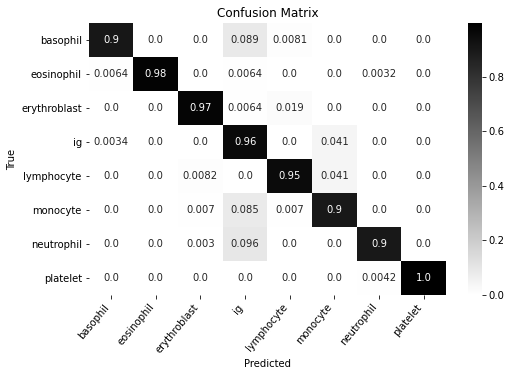

In [131]:
tm.plot_CM_heatmap(y_test, y_pred, labels, save=True, model_nm = model_name, figsize = (8,5))

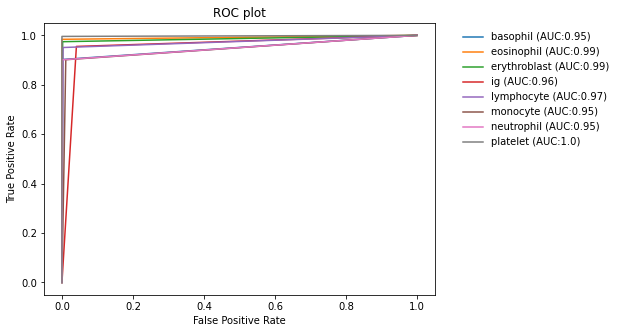

Macro AUC: 0.9690825271337162


In [132]:
tm.plot_multiclass_ROC(y_test, y_pred, labels, figsize=(7, 5), save=True, model_nm = model_name)

### **Examples of predictions**

In [12]:
import glob 
from PIL import Image

image_directory =f"{split_data_path}/test/"

files = glob.glob(f"{image_directory}/**/*")
images_list = []
orig_labels = []

for file in files:
    subdirectory, filename = file.split("/")[-2:]
    img1 = Image.open(file)
    img1_resized = img1.resize((400,400))
    x = image.img_to_array(img1_resized)*1./255
    x = np.expand_dims(x, axis=0)
    orig_labels.append(dir_dictionary[subdirectory])
    images_list.append(x)

images = np.vstack(images_list)
preds_probs = model.predict(images, batch_size = 16)

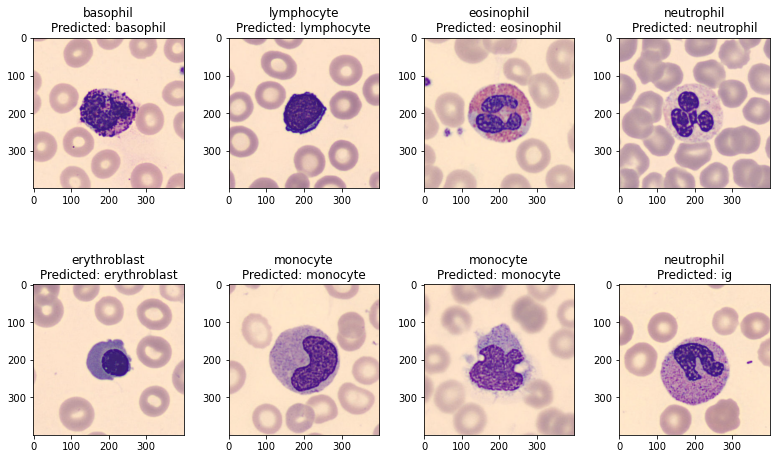

In [13]:
# display 8 images from the test sample along with 
# their predicted classes

indices = [random.randint(0,len(orig_labels)) for i in range(8)]

fig, axs = plt.subplots(2,4, figsize=(11,7))
fig.tight_layout() 

for n,idx in enumerate(indices):
    plt.subplot(2,4,n+1)
    orig  = orig_labels[idx]
    pred = preds_probs.argmax(axis=1)[idx]
    orig = abbreviation_dict[classes_dictionary[orig]]
    pred = abbreviation_dict[classes_dictionary[pred]]
    title = f"{orig}\nPredicted: {pred}"
    plt.title(title)
    plt.imshow(images[idx,:,:,:])

plt.savefig(f"../figures/{model_name}_examples.png")
plt.show()